# Проект 4. Компьютер говорит 'Нет'
## Прогнозирование вероятности дефолта заемщика

In [1]:
!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [2]:
from pandas import Series
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import datetime as dt
from itertools import combinations

from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

from sklearn.metrics import confusion_matrix

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.stats import uniform,ttest_ind

In [3]:
RANDOM_SEED = 42

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


Посмотрим на данные:

| Наименование столбца | Значение столбца |
| :--------- |:---------------------|
| *client_id* | идентификатор клиента |
| *education* | уровень образования |
| *sex* | пол заёмщика |
| *age* | возраст заёмщика |
| *car* | флаг наличия автомобиля |
| *car_type* | флаг автомобиля-иномарки |
| *decline_app_cnt* | количество отказанных прошлых заявок |
| *good_work* | флаг наличия «хорошей» работы |
| *bki_request_cnt* | количество запросов в БКИ |
| *home_address* | категоризатор домашнего адреса |
| *work_address* | категоризатор рабочего адреса |
| *income* | доход заёмщика |
| *foreign_passport* | наличие загранпаспорта |
| *default* | наличие дефолта |

### Анализ и предобработка данных

In [6]:
# Добавим функцию для вывода информации по выбросам
def blowout(value):
    median = data[value].median()
    IQR = data[value].quantile(0.75) - data[value].quantile(0.25)
    perc25 = data[value].quantile(0.25)
    perc75 = data[value].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

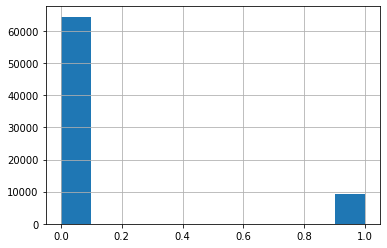

In [7]:
# построение диаграммы для оценки количества клиентов с дефолтом/ без дефолта
h = data['default'].hist()
fig = h.get_figure()

Значения переменной 0/1 соответственно 0 - без дефолта, 1 - соверщивших дефолт.
На основании данной диаграммы можно заметить, что у банка больше клиентов без дефолта

In [8]:
# найдем средний доход по каждому типу образования
income_mean = round(data.groupby(['education']).income.mean())
income_mean.sort_values(inplace=True)

In [9]:
income_mean

education
SCH    31960.0
UGR    39392.0
GRD    54664.0
PGR    77548.0
ACD    82967.0
Name: income, dtype: float64

In [10]:
# Признак уровень дохода
# На основании среднего уровня дохода от образования создадим новый признак
# * 1 000 - 35 000
# * 35 000 - 50 000
# * 50 000 - 75 000
# * более 75 000
# --------------------------------------------------------------------------------------------------------
data['new_income'] = np.where((data['income'] >= 1000) & (data['income'] < 35000), 0,
                              np.where((data['income'] >= 35000) & (data['income'] < 50000), 1,
                                       np.where((data['income'] >= 50000) & (data['income'] < 75000), 2,
                                                np.where(data['income'] >= 75000, 3, None))))
# --------------------------------------------------------------------------------------------------------

In [11]:
# рассмотрим тип данных и наличие пропусков
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
 14  new_income        73799 non-null  object
dtypes: int64(9), object(6)
memory usage: 8.4+ MB


client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
new_income            0
dtype: int64

В данных о клиентах присутствуют переменные типов int64 и object, а также есть пропущенные значения в информации об образовании клиентов education. Необходима предварительная очистка и подготовка данных 

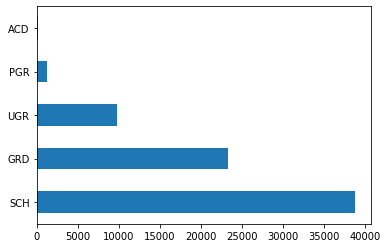

In [12]:
data['education'].value_counts().plot.barh()

In [13]:
# для отображения данных на гистрогамме по пропущенным значениям используем
data['education'] = data['education'].where(
    (pd.notnull(data['education'])), 'None')

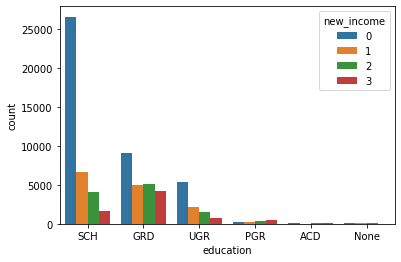

In [14]:
# построим гистограмму распределения категориального признака образования в зависсимости от дохода
sns.countplot(x="education", hue='new_income', data=data)

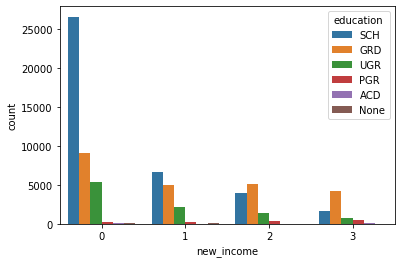

In [15]:
# построим гистограмму распределения категориального признака образования в зависсимости от дохода
sns.countplot(x="new_income", hue='education', data=data)

Построив графики по другим параметрам, видно, что с данным типом образования у клиентов чаще (именно чаще) других нет машин/ иномарок/ хорошей работы.
У клиентов с отсутствующими данными также большое количество значений соответствует именно этому типу образования, поэтому можно заменить на часто встречающееся значение SCH

In [16]:
# делаем замену пропущенных значений на чаще встречающеся значение. Осуществим проверку
data['education'].replace(['None'], 'SCH', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73799 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
 14  new_income        73799 non-null  object
dtypes: int64(9), object(6)
memory usage: 8.4+ MB


In [17]:
# дополнительная проверка результата
data['education'].value_counts()

SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [18]:
# вариант замены пустых значений на часто повторяющиеся при соответствующем уровне дохода
# (на kaggle данный код сработал здесь возникает ошибка)
# -------------------------------------------------------------------------------------------------------------------------
#df = data[['income','education']].value_counts().reset_index()
# for i in range(0,len(data['education'])):
#    if data['education'][i] == 'None':
#        for j in range(0,len(df)):
#            if data['income'][i] == df['income'][j]:
#                new_zna = df['education'][j]
#                data['education'][i] = new_zna
#                break
# data[data['education'] == 'None']
# -------------------------------------------------------------------------------------------------------------------------

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа**

In [19]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'new_income']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']

# Визуализация

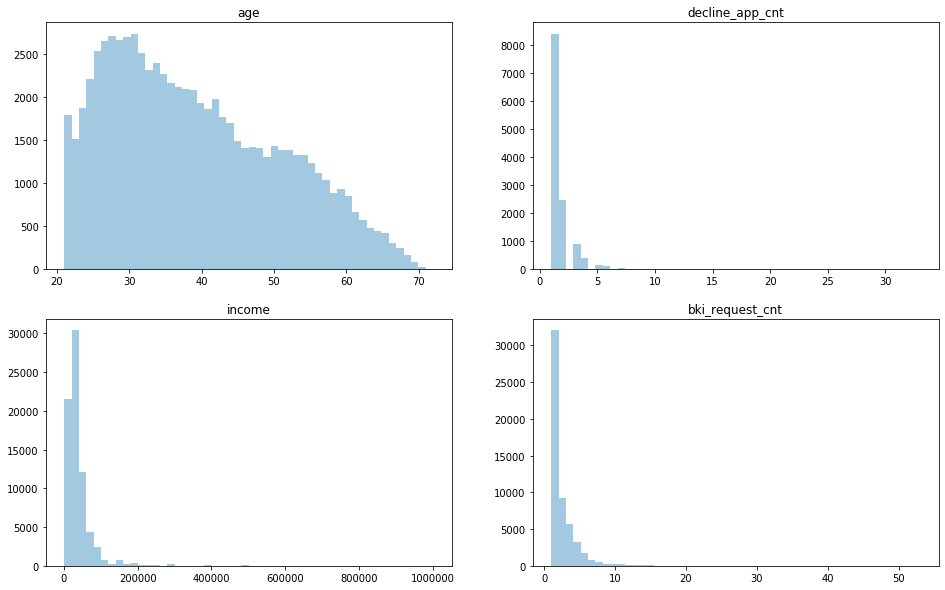

In [20]:
# таким образом у нас только 4 числовые переменные 'age', 'income', 'bki_request_cnt', 'decline_app_cnt'
# рассмотрим каждое из них
n_bins = 50
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, case in enumerate(num_cols):
    axes[i].hist(data[case][data[case].dropna() > 0],
                 bins=n_bins, color='#a3c9e0')
    axes[i].set_title(case)

In [21]:
# посмотрим на выбросы
blowout('income')
blowout('age')

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].


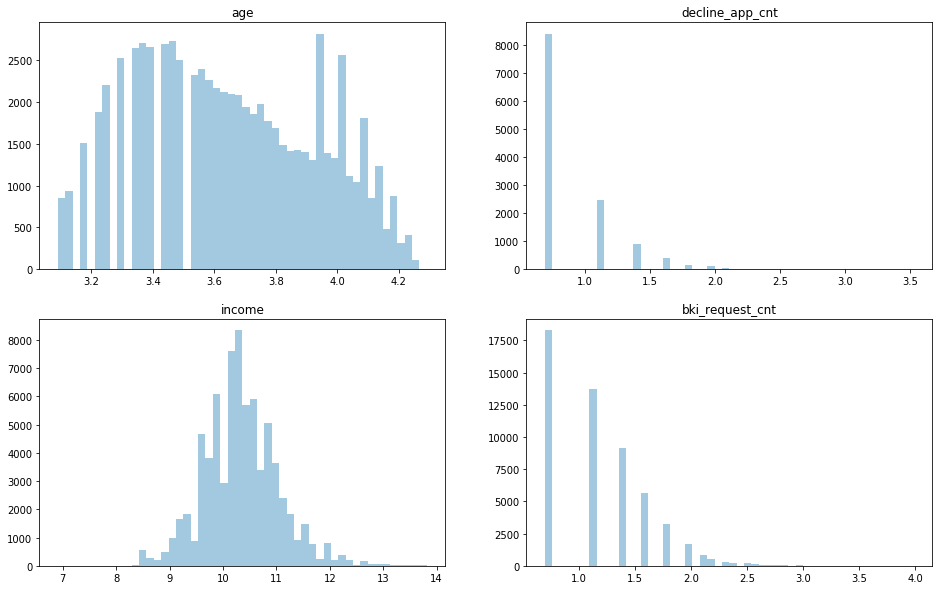

In [22]:
# логарифмируем и смотрим как изменились значения (кроме skore_bki)
n_bins = 50
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, case in enumerate(num_cols):
    data[case] = np.log(data[case] + 1)
    axes[i].hist(data[case][data[case].dropna() > 0],
                 bins=n_bins, color='#a3c9e0')
    axes[i].set_title(case)

In [23]:
# посмотрим на выбросы после логарифмирования
blowout('income')
blowout('age')

25-й перцентиль: 9.90353755128617, 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
25-й перцентиль: 3.4339872044851463, 75-й перцентиль: 3.8918202981106265, IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465].


После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост. 
Логарифмирования выбросы стали меньше

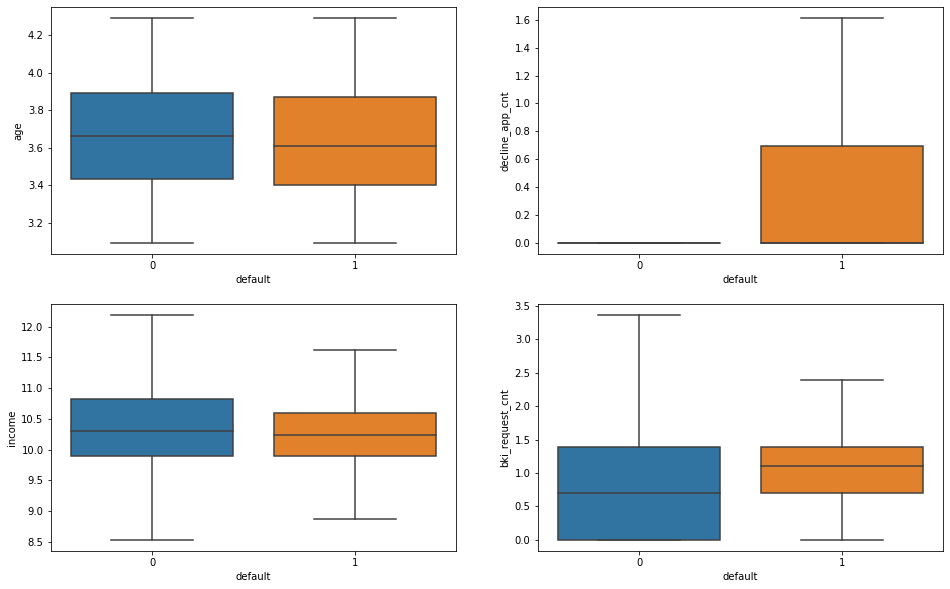

In [24]:
# построим boxplot для численных переменных зависсимости от default
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data,
                orient='v', ax=axes[i], showfliers=False)

На основании построенной визуализации можно сделать следующие выводы:
* *Дефолтные клиенты в среднем младше*
* *Дефолтные клиенты в среднем имеют большее количество отмененных заявок*
* *Дефолтные клиенты в среднем имеют больше запросов в БКИ*
* *Дефолтные клиенты в среднем имеют более низкий доход*

In [25]:
# Рассмотрим признак decline_app_cnt более детально
data['decline_app_cnt'].value_counts()

0.000000    61214
0.693147     8397
1.098612     2468
1.386294      903
1.609438      414
1.791759      165
1.945910      113
2.079442       48
2.302585       24
2.197225       19
2.397895       11
2.484907        9
2.639057        3
2.708050        2
2.833213        2
2.564949        2
2.772589        1
3.218876        1
3.526361        1
2.995732        1
3.135494        1
Name: decline_app_cnt, dtype: int64

In [26]:
# Создадим на основе данного decline_app_cnt новый признак наличия отказанных про
data['decline_app_YN'] = data.apply(
    lambda x: 0 if x['decline_app_cnt'] == 0 else 1, axis=1)

In [27]:
data['decline_app_YN'].value_counts()

0    61214
1    12585
Name: decline_app_YN, dtype: int64

In [28]:
# добавим новый признак в перечень к бинарным переменным и осуществим проверку
bin_cols.append('decline_app_YN')
print(bin_cols)

['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'decline_app_YN']


# Оценка корреляций

Сильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.
Оценим корреляцию Пирсона для непрерывных переменных по формуле:
$${r_{xy}} = \frac{\sum ({x_i} - \overline{x}) * ({y_i} - \overline{y})}{\sqrt {\sum ({x_i} - \overline{x})^2 * ({y_i} - \overline{y})^2}}$$

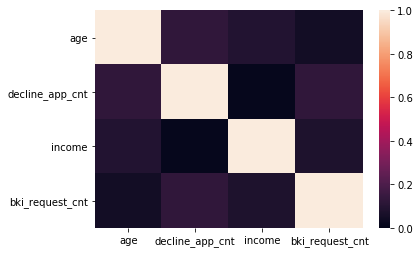

In [29]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Взаимосвязь представленных признаков по Пирсону слабая

# Значимость непрерывных переменных

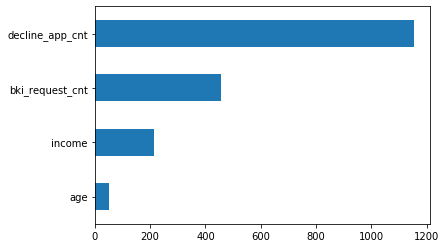

In [30]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Из графика видно, что значение *f*-статистики выше у признака decline_app_cnt. Соответственно данный признак является самым значимым из числовых 

# Категориальные переменные

In [31]:
# Построим таблицу для соответствия бинарных признаков некоторому числу
label_encoder = LabelEncoder()

for i, letter in enumerate(bin_cols):
    mapped_education = pd.Series(label_encoder.fit_transform(data[letter]))
    # убедимся в преобразовании
    print(letter, ':', dict(enumerate(label_encoder.classes_)))

sex : {0: 'F', 1: 'M'}
car : {0: 'N', 1: 'Y'}
car_type : {0: 'N', 1: 'Y'}
foreign_passport : {0: 'N', 1: 'Y'}
good_work : {0: 0, 1: 1}
decline_app_YN : {0: 0, 1: 1}


In [32]:
# Преобразууем все бинарные признаки с помощью класса LabelEncoder и убедимся, что все преобразования выполнены верно
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,new_income,decline_app_YN
0,25905,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0,0,1
3,16222,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0,0,0


In [33]:
# Преобразуем единственный не преобразованный категориальный признак- education и убедимся, что все преобразования выполнены верно
education_range = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}

data['education'] = data['education'].apply(
    lambda x: education_range[x] if x in education_range else None)
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,new_income,decline_app_YN
0,25905,1,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0,0,0
1,63161,1,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0,0,0
2,25887,1,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0,0,1
3,16222,1,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0,0,0
4,101655,2,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0,0,0


### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

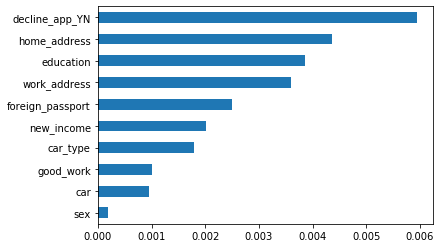

In [34]:
imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Из графика следует, что самый важный признак из категориальных home_address.
Признак пол является наименее важным по мнению mutual_info_classif

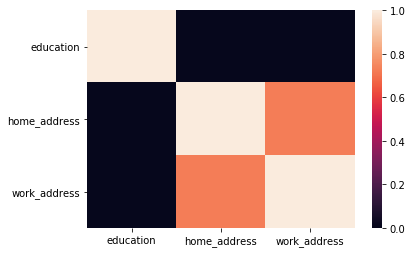

In [35]:
sns.heatmap(data[cat_cols].corr().abs(), vmin=0, vmax=1)

# Подготовка данных к машинному обучению

Перед обучением регрессии необходимо стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории

In [36]:
cat_cols_zna = list(set(cat_cols) - set(['work_address']))
X_cat = OneHotEncoder(sparse=False).fit_transform(data[cat_cols_zna].values)

In [37]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [38]:
# Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

Подготовка признаков для модели завершена.

In [39]:
# Разделим данные для обучения
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

In [52]:
X

array([[ 1.71113664, -0.42001208, -0.78501579, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5399884 , -0.42001208, -0.70752611, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39343857,  2.60673323, -0.05288771, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.66507223, -0.42001208,  0.5282444 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.89146325, -0.42001208, -1.25140899, ...,  0.        ,
         0.        ,  0.        ],
       [-0.35072683, -0.42001208, -0.31419734, ...,  0.        ,
         0.        ,  0.        ]])

# Обучение модели

In [41]:
# Модель для классификации
model = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr',
                           class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42,
                   solver='liblinear')

In [42]:
Y_predicted = model.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test, Y_predicted))
print('precision_score: ', precision_score(y_test, Y_predicted))
print('recall_score: ', recall_score(y_test, Y_predicted))
print('f1_score: ', f1_score(y_test, Y_predicted))

accuracy_score:  0.6237127371273713
precision_score:  0.19264390565726539
recall_score:  0.6392993979200876
f1_score:  0.29607097591888465


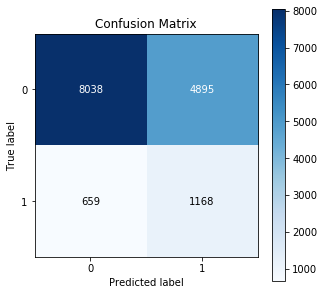

In [43]:
# Построим матрицу ошибок
n = confusion_matrix(y_test, Y_predicted)
n = pd.crosstab(y_test, Y_predicted)
tn, fp, fn, tp = confusion_matrix(y_test, Y_predicted).ravel()
skplt.metrics.plot_confusion_matrix(y_test, Y_predicted, figsize=(5, 5))

# Оценка качества модели

В качестве методов оценки прогностической способности модели будет использоваться ROC-анализ.

Классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

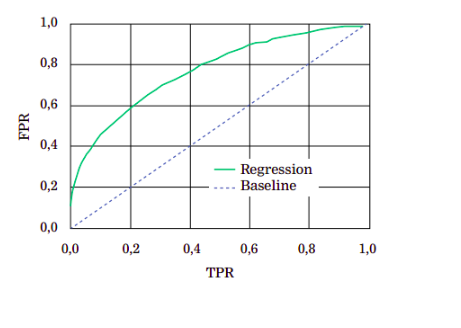

In [44]:
url = 'https://lms.skillfactory.ru/assets/courseware/v1/7b2082e0bb1ef965189eb9a354859a84/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/dst-score-16.png'
Image.open(urlopen(url))

В нашем примере положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.

→ Доля положительных результатов у «плохих» заемщиков (истинно положительных результатов) — это чувствительность модели (Sensitivity), то есть способность модели правильно определять «плохих» заемщиков и минимизировать убытки, связанные с выдачей кредита «плохому» клиенту. 

→ Доля отрицательных результатов у «хороших» заемщиков (истинно отрицательных результатов) — это специфичность модели (Specificity). Здесь речь уже идёт о способности модели правильно определять «хороших» заемщиков и минимизировать убытки, связанные с отказом в выдаче кредита добросовестному клиенту. 



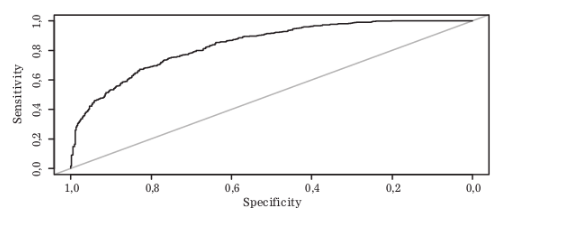

In [45]:
url = 'https://lms.skillfactory.ru/assets/courseware/v1/74e9564907091d0e3fdc95af5e8f4998/asset-v1:Skillfactory+DST-12+11MAR2020+type@asset+block/dst-score-17.png'
Image.open(urlopen(url))

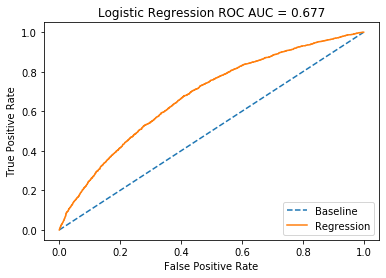

In [46]:
# Написав код для построения ROC AUС, получили значение метрики 0.677:
probs = model.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Найдем оптимальное значение параметра регуляризации для логистической регрессии. 
В scikit-learn есть два общих подхода к поиску: с помощью GridSearchCV  и RandomizedSearchCV. 
В этом примере мы рассмотрим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией.

### Вариант 1

In [47]:
from sklearn.model_selection import GridSearchCV
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0.1, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, n_jobs=-1)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.2589254117941673


In [48]:
# Модель для классификации
model2 = LogisticRegression(random_state=RANDOM_SEED, multi_class='ovr',
                            class_weight='balanced', solver='liblinear', C=1.2589254117941673
                            , penalty='l1')
model2.fit(X_train, y_train)

preds = model2.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test, preds))
print('precision_score: ', precision_score(y_test, preds))
print('recall_score: ', recall_score(y_test, preds))
print('f1_score: ', f1_score(y_test, preds))

accuracy_score:  0.6236449864498645
precision_score:  0.19261213720316622
recall_score:  0.6392993979200876
f1_score:  0.2960334558357623


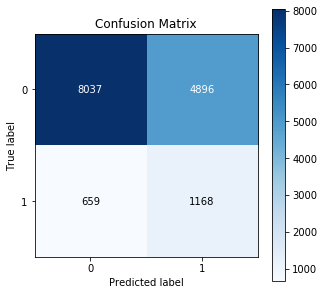

In [49]:
# Построим матрицу ошибок
n = confusion_matrix(y_test, preds)
n = pd.crosstab(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
skplt.metrics.plot_confusion_matrix(y_test, preds, figsize=(5, 5))

### Вариант 2

In [50]:
# Вариант 2
model3 = LogisticRegression(multi_class='ovr', class_weight='balanced',
                            solver='liblinear', random_state=RANDOM_SEED)
param_grid = [
    {'penalty': ['l1'], 'C':[0.1, 1, 10], 'max_iter':[1000], 'tol':[1e-5]},
    {'penalty': ['l2'], 'C':[0.1, 1, 10], 'max_iter':[1000], 'tol':[1e-5]},
    {'penalty': ['none'], 'max_iter':[1000], 'tol':[1e-5]},
]
gridsearch = GridSearchCV(model3, param_grid, scoring='f1', n_jobs=-1, cv=5)

model3.fit(X_train, y_train)

preds3 = model3.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test, preds3))
print('precision_score: ', precision_score(y_test, preds3))
print('recall_score: ', recall_score(y_test, preds3))
print('f1_score: ', f1_score(y_test, preds3))

accuracy_score:  0.6237127371273713
precision_score:  0.19264390565726539
recall_score:  0.6392993979200876
f1_score:  0.29607097591888465


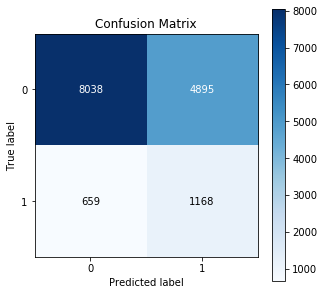

In [51]:
# Построим матрицу ошибок
n = confusion_matrix(y_test, preds3)
n = pd.crosstab(y_test, preds3)
tn, fp, fn, tp = confusion_matrix(y_test, preds3).ravel()
skplt.metrics.plot_confusion_matrix(y_test, preds3, figsize=(5, 5))

### Выводы

* *Метрика accuracy_score (доля правильных ответов) при первом варианте стал хуже при варианте с разными вариантами регуляризации результат идентичен*
* *Метрика precision_score (метрика, измеряющая, насколько много из принятых моделью положительных объектов в дейтвительности являются положительными) при первом варианте стал хуже при варианте с разными вариантами регуляризации результат идентичен*
* *Метрика recall_score (метрика, измеряющая, насколько много положительных объектов из всех положительных объектов модель выбрала) не изменился*
* *Метрика f1_score аналогично при первом варианте стал хуже при варианте с разными вариантами регуляризации результат идентичен, так как он учитывает одновременно precision и recall*